### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

In [167]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [168]:
# Пути к файлам
DATASET_PATH_TRAIN = 'train.csv'
DATASET_PATH_TEST = 'test.csv'
DATASET_PATH_PRED = 'KovalevaIV_predictions.csv'

In [169]:
# Загрузка тренировочных данных
df_train = pd.read_csv(DATASET_PATH_TRAIN)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [170]:
# Загрузка тестовых данных
df_test = pd.read_csv(DATASET_PATH_TEST)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


Описание датасета:
Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [171]:
# Выводим информацию о тренировочном датасете
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В датасете есть три признака типа object: Ecology_2, Ecology_3, Shops_2.
По двум признакам есть пропущенные значения: LifeSquare, Healthcare_1.

#### Проработка категорийных признаков

In [172]:
obj_features = df_train.select_dtypes(include='object').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [173]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [174]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [175]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Все три переменные принимают только два значения 'A' и 'B'. Заменим их на численные '1' и '0' соответственно.

In [177]:
df_train.loc[df_train['Ecology_2'] == 'B', 'Ecology_2'] = 0
df_train.loc[df_train['Ecology_2'] == 'A', 'Ecology_2'] = 1
df_train['Ecology_2'].value_counts()

0    9903
1      97
Name: Ecology_2, dtype: int64

In [178]:
df_train.loc[df_train['Ecology_3'] == 'B', 'Ecology_3'] = 0
df_train.loc[df_train['Ecology_3'] == 'A', 'Ecology_3'] = 1
df_train['Ecology_3'].value_counts()

0    9725
1     275
Name: Ecology_3, dtype: int64

In [179]:
df_train.loc[df_train['Shops_2'] == 'B', 'Shops_2'] = 0
df_train.loc[df_train['Shops_2'] == 'A', 'Shops_2'] = 1
df_train['Shops_2'].value_counts()

0    9175
1     825
Name: Shops_2, dtype: int64

In [180]:
# Поменяем тип на int64
df_train['Ecology_2'] = df_train['Ecology_2'].astype('int64')
df_train['Ecology_3'] = df_train['Ecology_3'].astype('int64')
df_train['Shops_2'] = df_train['Shops_2'].astype('int64')

In [181]:
# Теперь все признаки являются количественными
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2          int64
Ecology_3          int64
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2            int64
Price            float64
dtype: object

#### Обработка пропусков

In [182]:
df_train.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [183]:
# Почти половина значений признака Healthcare_1 пропущено. Мы не будем учитывать этот признак при прогнозировании.
df_train.drop(['Healthcare_1'], axis=1, inplace=True)

In [184]:
# Признак LifeSquare
df_train['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [185]:
# Заменим пропущенные значения признака LifeSquare на медиану
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['LifeSquare'].median()

In [186]:
# Теперь все признаки численные и без пропусков
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Price  

#### Обработка выбросов

In [187]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.009700,0.027500,24.687000,5352.157400,8.039200,1.319500,4.231300,0.082500,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,0.000000,0.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,0.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,0.000000,0.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,0.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,0.000000,0.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,0.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570


##### Rooms

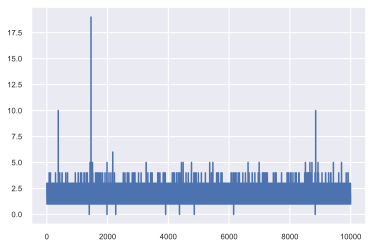

In [188]:
plt.plot(df_train['Rooms'])
plt.show()

In [189]:
# Параметр Rooms имеет три выброса: 10 и 19
df_train[df_train['Rooms']>9]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,0,0,74,19083,2,5,15,0,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,0,0,1,264,0,0,1,0,78364.616704
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,0,0,25,5648,1,2,4,0,172329.270863


In [190]:
# Избавимся от них
df_train.drop(df_train[(df_train['Rooms'] > 9)].index, axis=0, inplace=True)    

##### Square

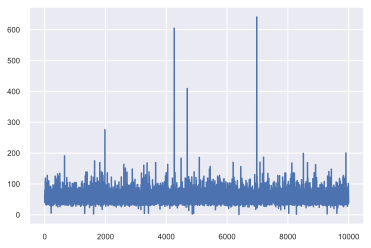

In [191]:
plt.plot(df_train['Square'])
plt.show()

In [192]:
# Square также имеет 3 выброса: 409, 604 и 641. 275 тоже выбивается, но оно кажется логичным при большой жилой площади, 5-ти комнатах и высокой цене.
df_train[df_train['Square']>250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,0,1,31,7010,5,3,7,0,455264.882666
4262,28,9,2.0,604.705972,32.781260,1.0,17,18.0,1977,0.161532,0,0,25,5648,1,2,4,0,187717.242538
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,0,0,26,3889,6,3,6,0,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,0,0,22,6398,141,3,23,0,133529.681562


In [193]:
# Убираем выбросы
df_train.drop(df_train[(df_train['Square'] > 300)].index, axis=0, inplace=True)    

##### LifeSquare	

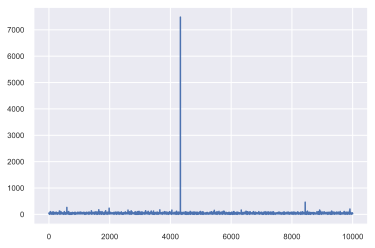

In [194]:
plt.plot(df_train['LifeSquare'])
plt.show()

In [195]:
# LifeSquare имеет 1 выброс 7480. Этот параметр точно неверный, так как он больше общей площади.
df_train[df_train['LifeSquare'] > 7000]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,0,0,2,469,0,0,0,0,217357.492366


In [196]:
df_train.drop(df_train[(df_train['LifeSquare'] > 7000)].index, axis=0, inplace=True)    

In [197]:
# В нашем Датасете есть 519 сторк, где жилая площадь дома превышает общую площадь. Это ажется ошибкой.
df_train[df_train['LifeSquare'] > df_train['Square'] ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,0,0,0,168,0,0,0,0,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,0,0,15,2787,2,0,7,0,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,0,0,1,264,0,0,1,0,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,0,0,53,13670,4,1,11,0,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,0,0,2,629,1,0,0,1,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,12918,23,2.0,51.440463,53.134243,51.0,3,17.0,2017,0.005767,0,0,1,388,0,0,0,0,88150.012510
9895,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,0,0,2,469,0,0,0,0,234194.837047
9902,14001,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,0,0,37,6856,84,2,5,0,381937.404161
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,0,0,53,14892,4,1,4,0,528560.506016


In [198]:
# Для таких строк заменим LifeSquare на Square, умноженную на среднюю долю жилой площади.
LifeSquare_Share = df_train['LifeSquare'].mean() / df_train['Square'].mean()
LifeSquare_Share

0.6307281455738624

In [199]:
df_train.loc[df_train['LifeSquare'] > df_train['Square'], 'LifeSquare'] = df_train.loc[df_train['LifeSquare'] > df_train['Square'], 'LifeSquare'] * LifeSquare_Share

##### KitchenSquare

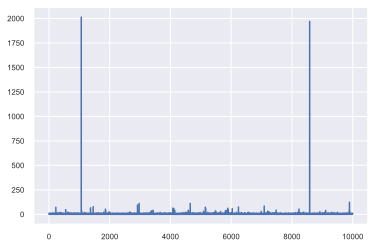

In [200]:
plt.plot(df_train['KitchenSquare'])
plt.show()

In [201]:
##### Параметр KitchenSquare имеет 2 выброса, удаляем их
df_train[df_train['KitchenSquare'] > 250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,0,0,2,629,1,0,0,1,108337.484207
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,0,0,30,5285,0,6,6,0,105539.556275


In [202]:
df_train.drop(df_train[(df_train['KitchenSquare'] > 250)].index, axis=0, inplace=True)    

In [203]:
# Также есть два примера, где площадь кухни больше общей площади.
df_train[df_train['KitchenSquare'] > df_train['Square'] ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,0,0,21,5731,0,1,0,0,160488.033165
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,0,0,4,915,0,0,0,0,99079.960518


In [204]:
# Заменим их на Square, умноженную на среднюю долю кухни
KitchenSquare_Share = df_train['KitchenSquare'].mean() / df_train['Square'].mean()
KitchenSquare_Share

0.1046011032427246

In [205]:
df_train.loc[df_train['KitchenSquare'] > df_train['Square'], 'KitchenSquare'] = df_train.loc[df_train['KitchenSquare'] > df_train['Square'], 'KitchenSquare'] * KitchenSquare_Share

##### HouseYear

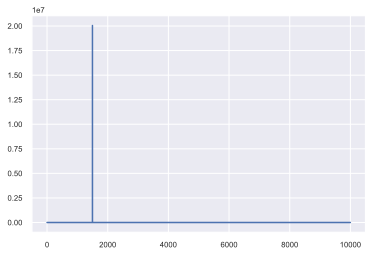

In [206]:
plt.plot(df_train['HouseYear'])
plt.show()

In [207]:
# Параметр HouseYear имеет 2 выброса, удаляем их
df_train[df_train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,0,0,30,6141,10,3,6,0,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,0,0,25,4756,16,5,8,0,243028.603096


In [209]:
df_train.drop(df_train[(df_train['HouseYear'] > 2020)].index, axis=0, inplace=True)    

Итак, мы почистили выборку от выбросов

In [210]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9989 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9989 non-null   int64  
 1   DistrictId     9989 non-null   int64  
 2   Rooms          9989 non-null   float64
 3   Square         9989 non-null   float64
 4   LifeSquare     9989 non-null   float64
 5   KitchenSquare  9989 non-null   float64
 6   Floor          9989 non-null   int64  
 7   HouseFloor     9989 non-null   float64
 8   HouseYear      9989 non-null   int64  
 9   Ecology_1      9989 non-null   float64
 10  Ecology_2      9989 non-null   int64  
 11  Ecology_3      9989 non-null   int64  
 12  Social_1       9989 non-null   int64  
 13  Social_2       9989 non-null   int64  
 14  Social_3       9989 non-null   int64  
 15  Helthcare_2    9989 non-null   int64  
 16  Shops_1        9989 non-null   int64  
 17  Shops_2        9989 non-null   int64  
 18  Price   

In [211]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000
mean,8381.474722,50.392832,1.887376,56.171538,34.290123,5.860989,8.524577,12.611072,1984.848834,0.118867,0.009711,0.027530,24.687957,5352.223846,8.030233,1.318050,4.228652,0.082491,214183.656998
std,4858.324061,43.584747,0.814018,19.154811,14.626780,5.072072,5.238726,6.774783,18.405355,0.119044,0.098068,0.163631,17.530597,4005.695552,23.806903,1.492289,4.803380,0.275125,92880.983492
min,0.000000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4168.000000,20.000000,1.000000,41.773176,24.774921,1.000000,4.000000,9.000000,1974.000000,0.017647,0.000000,0.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,0.000000,153912.044504
50%,8392.000000,36.000000,2.000000,52.512769,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,0.000000,0.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,0.000000,192302.751941
75%,12591.000000,75.000000,2.000000,65.892584,39.571290,9.000000,12.000000,17.000000,2001.000000,0.195781,0.000000,0.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,0.000000,249174.529858
max,16798.000000,209.000000,6.000000,275.645284,291.058090,123.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570


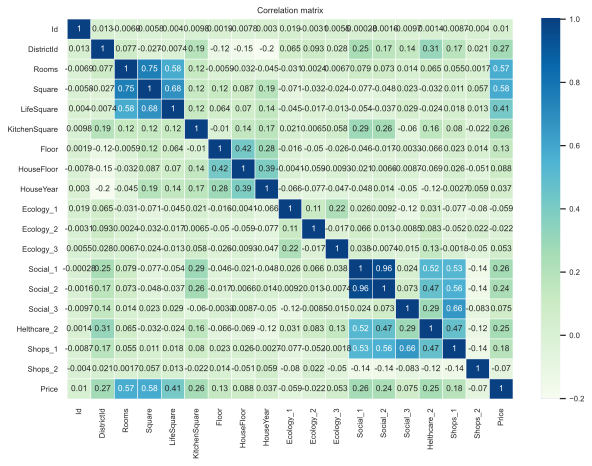

In [212]:
# Построим матрицу корреляций, для того чтобы проверить, какие из признаков влияют на prise
plt.figure(figsize = (10,7))

sns.set(font_scale=0.7)
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Тренировочный Датасет готов к использованию. 

Подготовим тестовый Датасет.

In [213]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [214]:
# Переводим категорийные признаки в числовые

df_test.loc[df_test['Ecology_2'] == 'B', 'Ecology_2'] = 0
df_test.loc[df_test['Ecology_2'] == 'A', 'Ecology_2'] = 1

df_test.loc[df_test['Ecology_3'] == 'B', 'Ecology_3'] = 0
df_test.loc[df_test['Ecology_3'] == 'A', 'Ecology_3'] = 1

df_test.loc[df_test['Shops_2'] == 'B', 'Shops_2'] = 0
df_test.loc[df_test['Shops_2'] == 'A', 'Shops_2'] = 1

df_test['Ecology_2'] = df_test['Ecology_2'].astype('int64')
df_test['Ecology_3'] = df_test['Ecology_3'].astype('int64')
df_test['Shops_2'] = df_test['Shops_2'].astype('int64')

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [215]:
# Удаляем столбец Healthcare_1
df_test.drop(['Healthcare_1'], axis=1, inplace=True)

In [216]:
# Удаляем выбросы

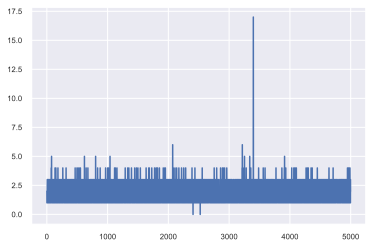

In [217]:
plt.plot(df_test['Rooms'])
plt.show()

In [218]:
df_test.drop(df_test[(df_test['Rooms'] > 10)].index, axis=0, inplace=True)    

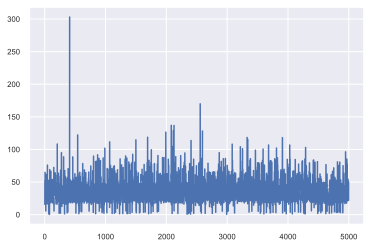

In [219]:
plt.plot(df_test['LifeSquare'])
plt.show()

In [220]:
df_test.drop(df_test[(df_test['LifeSquare'] > 200)].index, axis=0, inplace=True)    

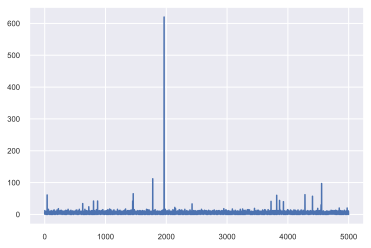

In [221]:
plt.plot(df_test['KitchenSquare'])
plt.show()

In [222]:
df_test.drop(df_test[(df_test['KitchenSquare'] > 200)].index, axis=0, inplace=True)    

In [223]:
df_test.drop(df_test[(df_test['HouseYear'] > 2020)].index, axis=0, inplace=True)    

In [59]:
df_train.loc[df_train['Ecology_3'] == 'B', 'Ecology_3'] = 0
df_train.loc[df_train['Ecology_3'] == 'A', 'Ecology_3'] = 1
df_train['Ecology_3'].value_counts()

0    9725
1     275
Name: Ecology_3, dtype: int64

In [274]:
# Заменим пропущенные значения признака LifeSquare на медиану
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()

#### Разбиваем тренировочный датасет на тренировочный и валидационный

In [275]:
features = df_train.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'
X = pd.DataFrame(df_train, columns=features)
y = pd.DataFrame(df_train, columns=[target])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

#### Модель

In [ ]:
На валидационном наборе модели LinearRegression, Lasso и Ridge дали похожий и слишком низкий результат (r2 score = 0.5). 
Наилучший результат был получен на модели RandomForestRegressor с параметрами n_estimators=1000, max_depth=9, max_features=6, random_state=42.

In [259]:
random_forest = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=6, random_state=42)

In [260]:
random_forest.fit(X_train, y_train)

<ipython-input-260-9cbe53f8ec61>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


RandomForestRegressor(max_depth=9, max_features=6, n_estimators=1000,
                      random_state=42)

In [261]:
y_pred = random_forest.predict(X_valid)
r2_random_forest = r2_score(y_valid, y_pred)
r2_random_forest

0.7287521356197346

#### Предсказываем цены для тестового датасета и выгружаем результат в файл.

In [277]:
X_test = df_test[features]
X_test.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,0,0,11,2748,1,0,0,0
1,2.0,69.263183,32.929275,1.0,6,1.0,1977,0.075779,0,0,6,1437,3,0,2,0
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,0,0,30,7538,87,5,5,0
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,0,0,23,4583,3,3,3,0
4,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,0,0,2,629,1,0,0,1


In [279]:
price = random_forest.predict(X_test)
pd.DataFrame({ 'Id': df_test['Id'], 'Price': price }).to_csv(DATASET_PATH_PRED, index=False)